In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [19]:
init_notebook()
figsize = (7,1.75)
fontsize = 11
Fig.config(fontsize, figsize)

In [4]:
dataf = "../../data/simplekv.csv"

In [5]:
!sha256sum $dataf

9e825a87ff70daf85addaa66c5e817977c49c2039dadf185b4f800a206b600d2  ../../data/simplekv.csv


In [6]:
def prefix_list(l, prefix):
    return [prefix + elem for elem in l]

In [7]:
df_raw = pd.read_csv(dataf, index_col=None)
print(df_raw)
index_vals =  ['a', 'b', 'c', 'd', 'e', 'f', 'g']
index_nv = prefix_list(index_vals, 'nv_')
index_v = prefix_list(index_vals, 'v_')
index_comb = index_v + ['drop'] + index_nv
df_raw.index = index_comb
df_raw = df_raw.T
del df_raw['drop']
df_raw = df_raw.T

          pmdk     snashot       msync  msync huge page
0   3189215170  2574674229  3294391724      47528705758
1   2559005741  2224604427  2375700349       6862043863
2   2424995653  2175474441  2235572465       2149039247
3   4381466661  3984501846  4859168296      19933829570
4    195416097   147864667   290415618       5905022071
5   3992143744  3233388773  4022491170      51264286100
6   3921751491  3099610030  4228233059      92684273079
7         pmdk     snashot       msync  msync huge page
8   3193541090  2677960726  3304056299      47569677637
9   2523571144  2221662855  2391032673       6730304023
10  2429818594  2156934793  2244657697       2160538351
11  4381546461  4076965744  4840172288      19975189585
12   196905334   156656979   288109916       5960855625
13  3969417184  3336766322  4041329799      51908197606
14  3940719386  3216510138  4259495169      99338540471


In [8]:
v = (df_raw.T[index_v]).T[['pmdk', 'snashot', 'msync', 'msync huge page']]
v.index = index_vals
v

,pmdk,snashot,msync,msync huge page
a,3189215170,2574674229,3294391724,47528705758
b,2559005741,2224604427,2375700349,6862043863
c,2424995653,2175474441,2235572465,2149039247
d,4381466661,3984501846,4859168296,19933829570
e,195416097,147864667,290415618,5905022071
f,3992143744,3233388773,4022491170,51264286100
g,3921751491,3099610030,4228233059,92684273079


In [9]:
nv = (df_raw.T[index_nv]).T['snashot']
nv.index = index_vals
nv

a    2677960726
b    2221662855
c    2156934793
d    4076965744
e     156656979
f    3336766322
g    3216510138
Name: snashot, dtype: object

In [10]:
df = pd.DataFrame()
df['PMDK'] = np.int_(v['pmdk'])
df['Snapy (Volatile)'] = np.int_(v['snashot'])
df['Snapy (Non-Volatile)'] = np.int_(nv)
df['msync (4KiB)'] = np.int_(v['msync'])
df['msync (2MiB)'] = np.int_(v['msync huge page'])
df.index = [val.capitalize() for val in index_vals]
df

,PMDK,Snapy (Volatile),Snapy (Non-Volatile),msync (4KiB),msync (2MiB)
A,3189215170,2574674229,2677960726,3294391724,47528705758
B,2559005741,2224604427,2221662855,2375700349,6862043863
C,2424995653,2175474441,2156934793,2235572465,2149039247
D,4381466661,3984501846,4076965744,4859168296,19933829570
E,195416097,147864667,156656979,290415618,5905022071
F,3992143744,3233388773,3336766322,4022491170,51264286100
G,3921751491,3099610030,3216510138,4228233059,92684273079


In [11]:
pmdk_col = df['PMDK']
df_norm = df.copy(deep=True)
for col in df:
    df_norm[col] = df[col]/pmdk_col
df_norm

,PMDK,Snapy (Volatile),Snapy (Non-Volatile),msync (4KiB),msync (2MiB)
A,1.0,0.807307,0.839693,1.032979,14.902947
B,1.0,0.869324,0.868174,0.928369,2.681527
C,1.0,0.897104,0.889459,0.921887,0.886203
D,1.0,0.909399,0.930503,1.109028,4.549579
E,1.0,0.756666,0.801659,1.486140,30.217685
F,1.0,0.809938,0.835833,1.007602,12.841293
G,1.0,0.790364,0.820172,1.078149,23.633388


In [12]:
Fig.config(12, (8.2, 2))

Plot saved as `plots/pathfinding/simplekv.png`

Plot saved as `plots/pathfinding/simplekv.png`

Using pdfcrop on `plots/pathfinding/simplekv.png` with command `pdfcrop plots/pathfinding/simplekv.pdf plots/pathfinding/simplekv.pdf`

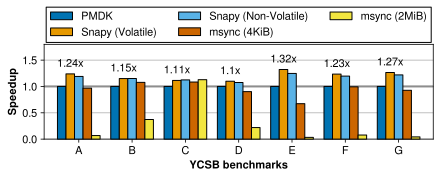

In [22]:
plt.rcParams["font.family"] = "freesans"
speedup = 1/df_norm
ax = speedup.plot.bar(**Fig.get_kwargs(width=0.8))
f = Fig(ax)
ax.set_ylim((0, 1.8))

f.fmt_legend(fontsize=fontsize)
# f.fmt_label('YCSB benchmarks', 'Relative performance')
f.fmt_label('YCSB benchmarks', 'Speedup')
f.add_bar_labels([False, True, False, False, False], precision=2, fontsize=fontsize, over_fig=False, alpha=0)
f.xrot(rot=0)
f.fmt_grid(axis='y')
ax.set_yticks(np.arange(0, 1.8, 0.5))
ax.axline((0, 1), (10, 1), zorder=0, color='black')
save_fig('simplekv')

In [14]:
df_norm

,PMDK,Snapy (Volatile),Snapy (Non-Volatile),msync (4KiB),msync (2MiB)
A,1.0,0.807307,0.839693,1.032979,14.902947
B,1.0,0.869324,0.868174,0.928369,2.681527
C,1.0,0.897104,0.889459,0.921887,0.886203
D,1.0,0.909399,0.930503,1.109028,4.549579
E,1.0,0.756666,0.801659,1.486140,30.217685
F,1.0,0.809938,0.835833,1.007602,12.841293
G,1.0,0.790364,0.820172,1.078149,23.633388
